## Try to get time iteration direct working

We want the possibility of using time iteration direct because it is much faster than time iteration, which will speed up the computation of equilibrium massively. 

In [23]:
# Setup
import numpy as np
import scipy.sparse as spa

from dolo import yaml_import
from dolo.algos.dtcscc.time_iteration import time_iteration, time_iteration_direct
import dolo.algos.dtcscc.distributions_general as dst
from dolo.numeric.misc import mlinspace
from dolo.numeric.discretization.quadrature import gauss_hermite_nodes
from dolo.numeric.discretization.discretization import rouwenhorst


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)

Nf = np.array([20, 20])

### Solve using time iteration and plot decision rules

In [3]:
# Note: time iteration need not converge monotonically. Reasonably slow: 6-7s per loop.
# dr = time_iteration(model, with_complementarities=True, verbose=False) 

In [3]:
dr = time_iteration_direct(model,with_complementarities=True, verbose=False)       # Direct doesn't use complementarities!

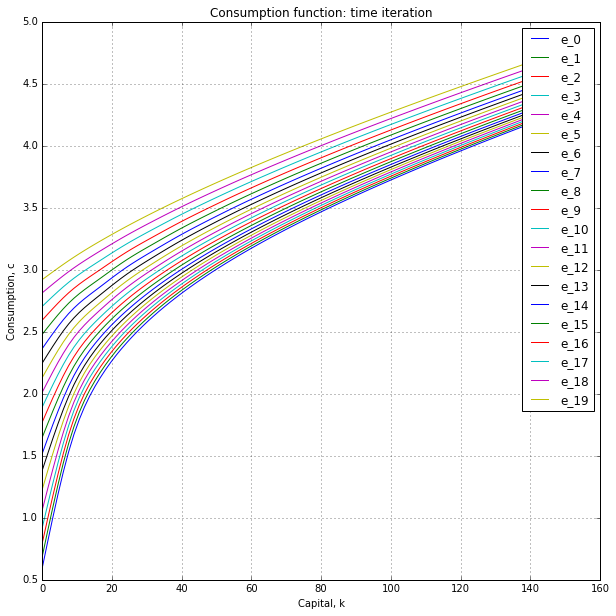

In [4]:

Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
# drc_direct = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()
#     drc_direct[:, i_e] = dr_direct(sgridf).flatten()

%matplotlib inline

plt.figure(figsize=(10, 10))
for i_e in range(Nf[1]):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function: time iteration')
plt.legend()
plt.grid()


### Compute stationary distribution 

In [6]:
# from dolo.numeric.discretization import quadrature
# sigma = np.array([[1,0.5],[0.5, 1]])
# Nq = np.array([7,7])
# nodes, weights = gauss_hermite_nodes(Nq, sigma, mu=None)
# nodes[1,0]

In [20]:
# g = model.functions['transition']    # g(s, x, e, p, out)
# parms = model.calibration['parameters']
# g(grid, grid[:,0], grid[:,1], parms)

In [57]:
Nexo = len(model.calibration['shocks'])
Nend = len(model.calibration['states']) - Nexo

grid = model.get_grid()
a = grid.a
b = grid.b
sgridf = mlinspace(a[:Nend],b[:Nend],Nf[:Nend])    # endogenous states

rho_e = model.calibration_dict['rho_e']
sig_e = model.calibration_dict['sig_e']
mgrid, Qm = rouwenhorst(rho_e, sig_e, Nf[1])


# tmp = np.linspace(a[i_s],b[i_s],Nf[i_s])

# for i_s in range(Nend-1):
    


In [60]:
mgrid

array([-2.00092468, -1.79030103, -1.57967738, -1.36905373, -1.15843008,
       -0.94780643, -0.73718278, -0.52655913, -0.31593548, -0.10531183,
        0.10531183,  0.31593548,  0.52655913,  0.73718278,  0.94780643,
        1.15843008,  1.36905373,  1.57967738,  1.79030103,  2.00092468])

In [ ]:
def fine_grid(model, Nf):

    grid = model.get_grid()
    a = grid.a
    b = grid.b
    sgridf = mlinspace(a,b,Nf)

    return sgridf



In [24]:
Nexo = len(model.calibration['shocks'])
Nend = len(model.calibration['states']) - Nexo

# Total number of continuous states
Ntot = np.prod(Nf)

# Create fine grid for the histogram
sgridf = fine_grid(model, Nf)
parms = model.calibration['parameters']

# Get the quadrature nodes for the iid normal shocks
distrib = model.get_distribution()
nodes, weights = distrib.discretize(orders=Nq)

# Find the state tomorrow on the fine grid
sprimef = dr_to_sprime(model, dr, Nf)


# Compute exogenous state transition matrices by discretizing the processes
# First state:

[nodes, Qm] = rouwenhorst(rho, sigma, N)

Qm = spa.csr_matrix((Ntot, Nf[Nend]))   # Start from first exogenous state
mgrid = np.unique(sgridf[:,Nend])
for i in range(Nq):
    mprimef = gtilde(model, sgridf[:,Nend], nodes[i])
    Qm += weights[i]*single_state_transition_matrix(mgrid, mprimef, Nf, Nf[Nend])
Qm = Qm.toarray()

# TODO: Finish extra dimensions. Tricky because of extra dimensions in Nq...
# Second (and further) state transitions created via repeated tensor products
# for i_m in range(Nend, Nend+Nexo+1):
#     Qtmp = spa.csr_matrix((Ntot, Nf[i_m]))   # Start from first exogenous state

In [7]:
L, QT = dst.stat_dist(model, dr, Nf, Nq=7, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.260547 

Iteration = 100, dist = 0.005009 

Iteration = 200, dist = 0.001238 

Iteration = 300, dist = 0.000242 

Iteration = 400, dist = 0.000045 

Iteration = 500, dist = 0.000008 

Iteration = 600, dist = 0.000002 

Iteration = 700, dist = 0.000000 

Iteration = 800, dist = 0.000000 

Iteration = 900, dist = 0.000000 



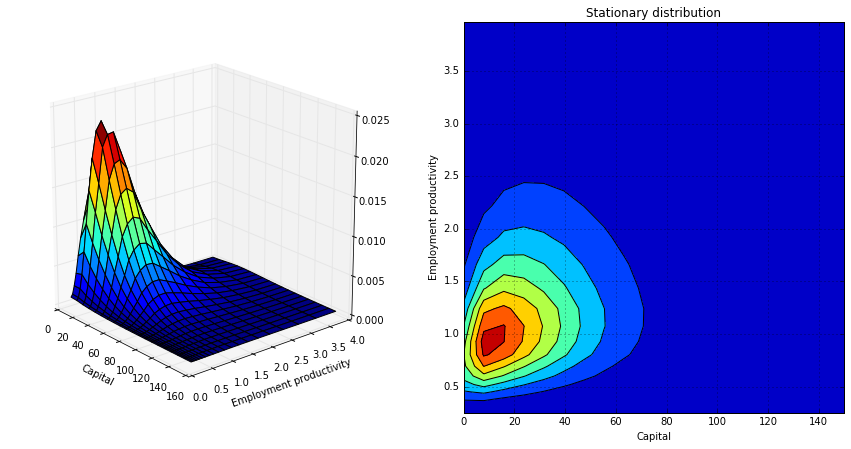

In [8]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf],order='F')    # Need Fortran order since variables are in a different order
sgridf = dst.fine_grid(model, Nf)
kgridf = np.unique(sgridf[:,0])
egridf = np.unique(sgridf[:,1])
# kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(15, 7))
# plt.subplot(121)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 320

ax = fig.add_subplot(122)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()

In [13]:
Kd, Ks, r = dst.supply_demand(model, 'kagg', 'r', Nf, numpoints=30, lower=40, upper=50, verbose=True)


Iteration = 0

Iteration = 1

Iteration = 2

Iteration = 3

Iteration = 4

Iteration = 5

Iteration = 6

Iteration = 7

Iteration = 8

Iteration = 9

Iteration = 10

Iteration = 11

Iteration = 12

Iteration = 13

Iteration = 14

Iteration = 15

Iteration = 16

Iteration = 17

Iteration = 18

Iteration = 19

Iteration = 20

Iteration = 21

Iteration = 22

Iteration = 23

Iteration = 24

Iteration = 25

Iteration = 26

Iteration = 27

Iteration = 28

Iteration = 29



In [11]:
# Profiling: A lot faster now that we're using time iteration direct.
%prun dst.supply_demand(model, 'kagg', 'r', Nf, numpoints=10, lower=40, upper=50, verbose=True)


(20, 70)

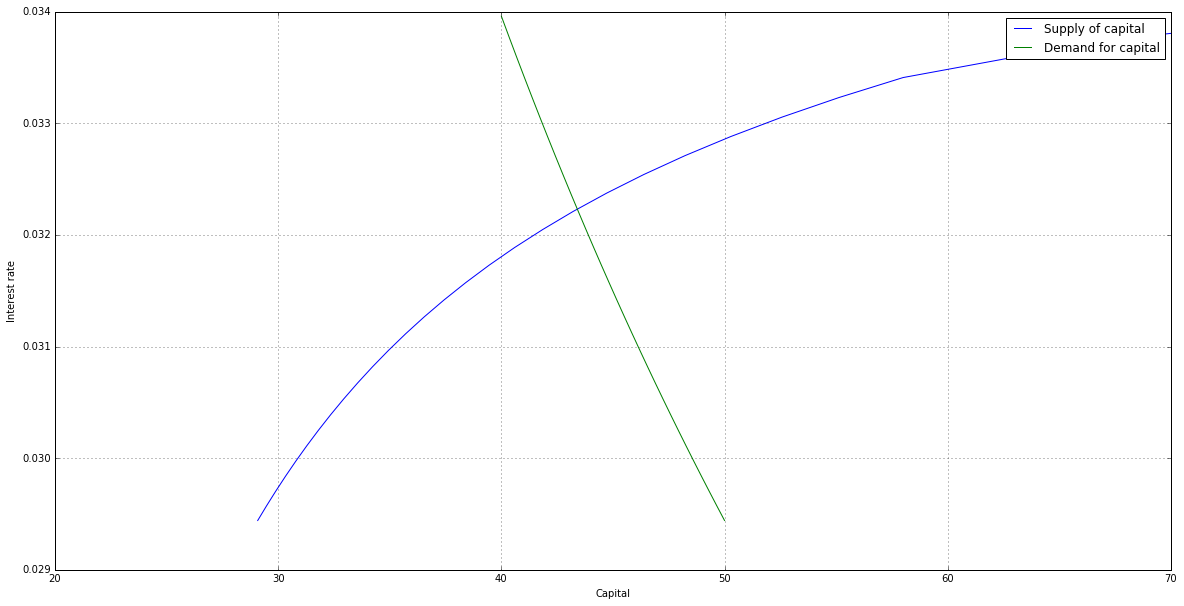

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
# plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
# plt.ylim(0.027, 0.034)
plt.xlim(20, 70)

### Compute the equilibrium interest rate 


In [15]:
K = dst.solve_eqm(model, Nf, Kinit=40, tolKeq=1e-4, verbose=True)

Iteration = 	0: K=	40.0000  Kagg=	77.2000

Iteration = 	1: K=	40.0372  Kagg=	68.2705

Iteration = 	2: K=	40.2065  Kagg=	66.2962

Iteration = 	3: K=	40.4925  Kagg=	63.1843

Iteration = 	4: K=	40.8536  Kagg=	60.8422

Iteration = 	5: K=	41.2699  Kagg=	56.0098

Iteration = 	6: K=	41.6491  Kagg=	53.3431

Iteration = 	7: K=	42.0070  Kagg=	50.6783

Iteration = 	8: K=	42.3143  Kagg=	48.8010

Iteration = 	9: K=	42.5755  Kagg=	47.3795

Iteration = 	10: K=	42.7920  Kagg=	46.2166

Iteration = 	11: K=	42.9627  Kagg=	45.3976

Iteration = 	12: K=	43.0956  Kagg=	44.7700

Iteration = 	13: K=	43.1949  Kagg=	44.3058

Iteration = 	14: K=	43.2661  Kagg=	43.9910

Iteration = 	15: K=	43.3159  Kagg=	43.7743

Iteration = 	16: K=	43.3495  Kagg=	43.6379

Iteration = 	17: K=	43.3720  Kagg=	43.5337

Iteration = 	18: K=	43.3854  Kagg=	43.4770

Iteration = 	19: K=	43.3933  Kagg=	43.4432

Iteration = 	20: K=	43.3979  Kagg=	43.4239

Iteration = 	21: K=	43.4004  Kagg=	43.4133

Iteration = 	22: K=	43.4017  Kagg=	43.4152

### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [16]:
model.set_calibration(kagg=K)
dr = time_iteration_direct(model, with_complementarities=True, verbose=False) 
L, QT = dst.stat_dist(model, dr, Nf, Nq=7, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.258541 

Iteration = 100, dist = 0.002936 

Iteration = 200, dist = 0.001394 

Iteration = 300, dist = 0.000607 

Iteration = 400, dist = 0.000254 

Iteration = 500, dist = 0.000106 

Iteration = 600, dist = 0.000044 

Iteration = 700, dist = 0.000018 

Iteration = 800, dist = 0.000008 

Iteration = 900, dist = 0.000003 

Iteration = 1000, dist = 0.000001 

Iteration = 1100, dist = 0.000001 

Iteration = 1200, dist = 0.000000 

Iteration = 1300, dist = 0.000000 

Iteration = 1400, dist = 0.000000 

Iteration = 1500, dist = 0.000000 



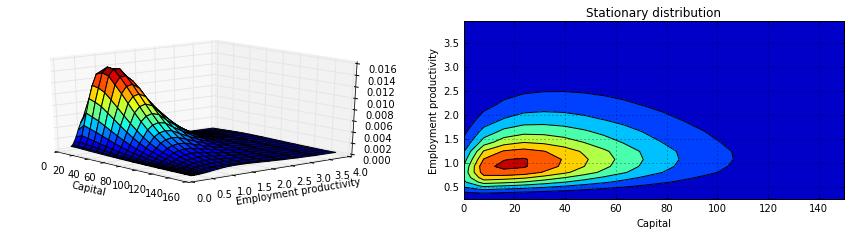

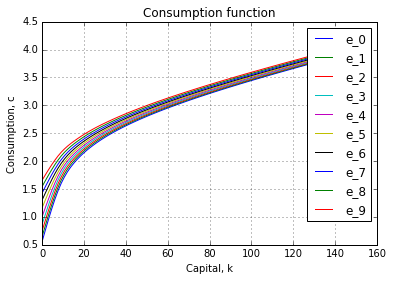

In [17]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf],order='F')    # Need Fortran order since variables are in a different order
sgridf = dst.fine_grid(model, Nf)
kgridf = np.unique(sgridf[:,0])
egridf = np.unique(sgridf[:,1])
# kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(15, 7))
# plt.subplot(121)
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 320

ax = fig.add_subplot(222)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()



Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()

ax = fig.add_subplot(223)
for i_e in range(10):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function')
plt.legend()
plt.grid()

In [8]:
Nexo = len(model.calibration['shocks'])
Nend = len(model.calibration['states']) - Nexo

In [10]:
Ng = np.array([10,20])

In [11]:
Ng[Nend]

20

### Plot the equilibrium stationary distribution and decision rules

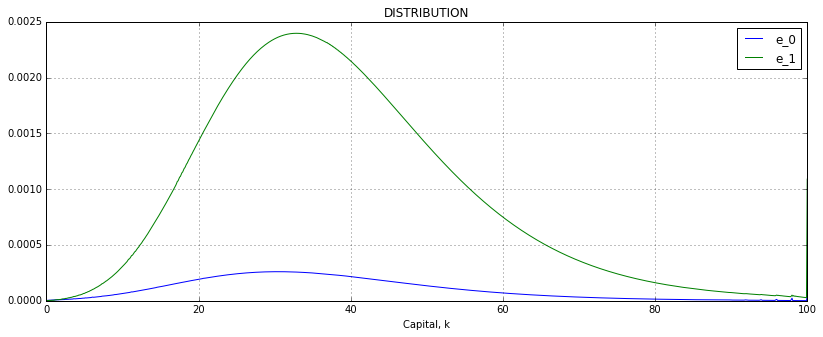

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

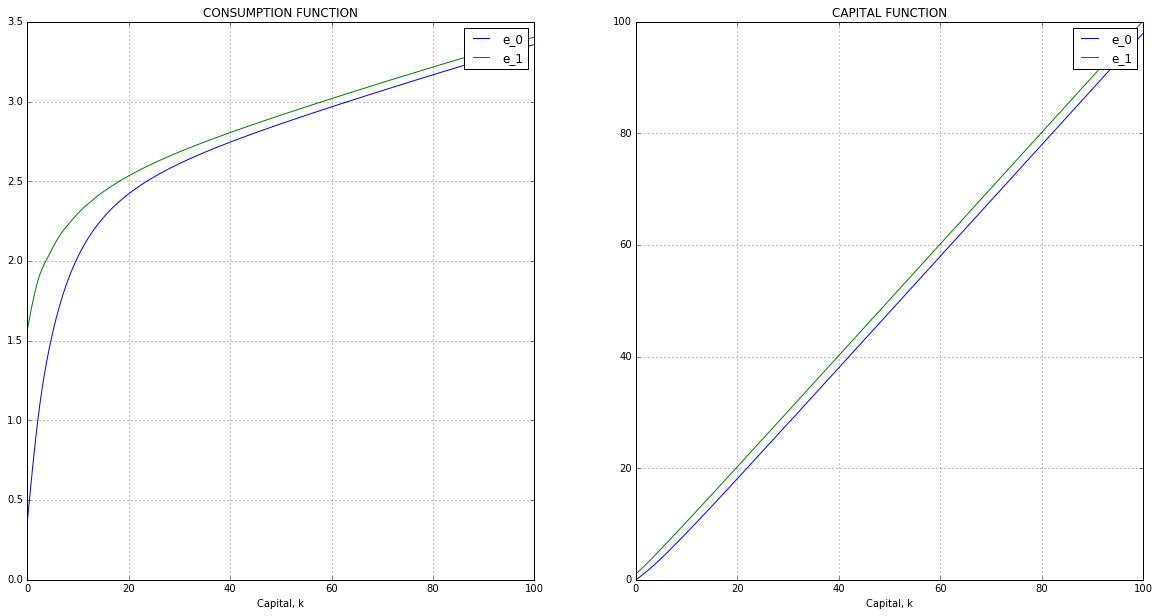

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

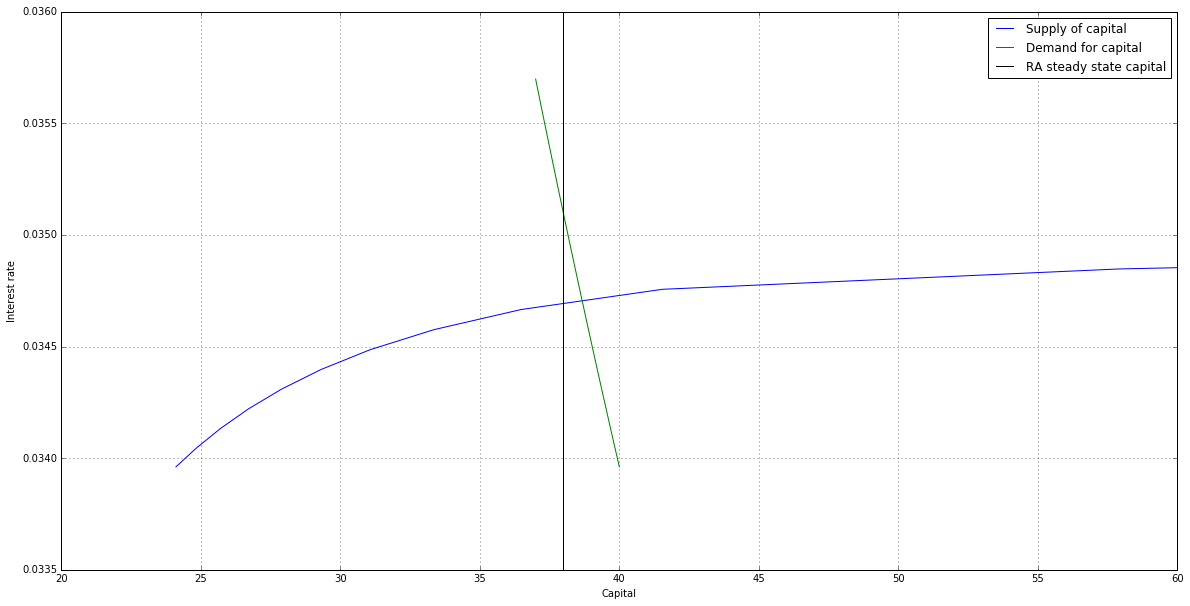

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 